In [ ]:
import argparse
import os
import sys
import pickle
import time
import subprocess
import shutil
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.rl.utils.visualizer import Visualizer
from khrylib.rl.core.policy_gaussian import PolicyGaussian
from khrylib.rl.core.critic import Value
from khrylib.models.mlp import MLP
from motion_imitation.envs.humanoid_im import HumanoidEnv
from motion_imitation.utils.config import Config


cfg = Config('0202', False, create_dirs=False)
# cfg = Config(cfg, False, create_dirs=False)
cfg.env_start_first = True
logger = create_logger(os.path.join(cfg.log_dir, 'log_eval.txt'))

"""make and seed env"""
dtype = torch.float64
torch.set_default_dtype(dtype)
torch.manual_seed(cfg.seed)
torch.set_grad_enabled(False)
env = HumanoidEnv(cfg)

env.seed(cfg.seed)


(75, 39)


[1]

In [16]:
env.model.opt.timestep


0.00222222222

In [ ]:
qpos = env.expert['qpos']
qpos.shape


(75, 39)

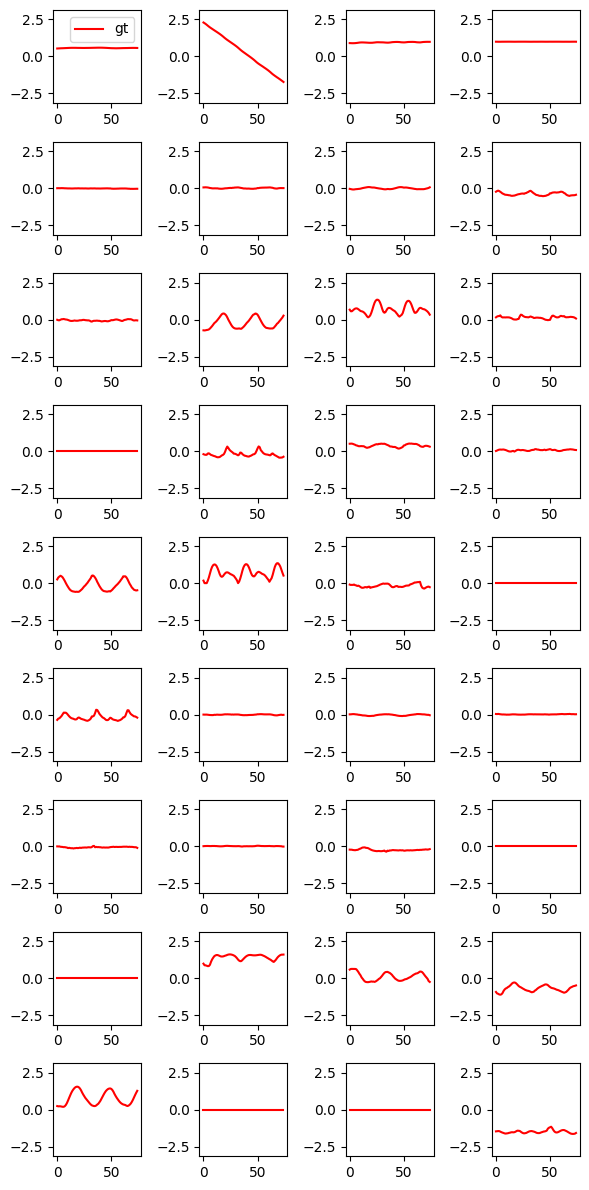

In [18]:
import matplotlib.pyplot as plt

def plot_qpos(qpos):
    fig, axs = plt.subplots(nrows=qpos.shape[1]//4, ncols=4, figsize=(6, 12))
    for i in range(qpos.shape[1]//4):
        for j in range(4):
            gt = qpos[:, i*4 + j]
            axs[i, j].plot(gt, 'r', label='gt')
            axs[i, j].set_ylim([-np.pi, np.pi])
            if i == 0 and j == 0:
                axs[i, j].legend()
    plt.tight_layout()
    plt.show()

# Example usage:
plot_qpos(qpos)

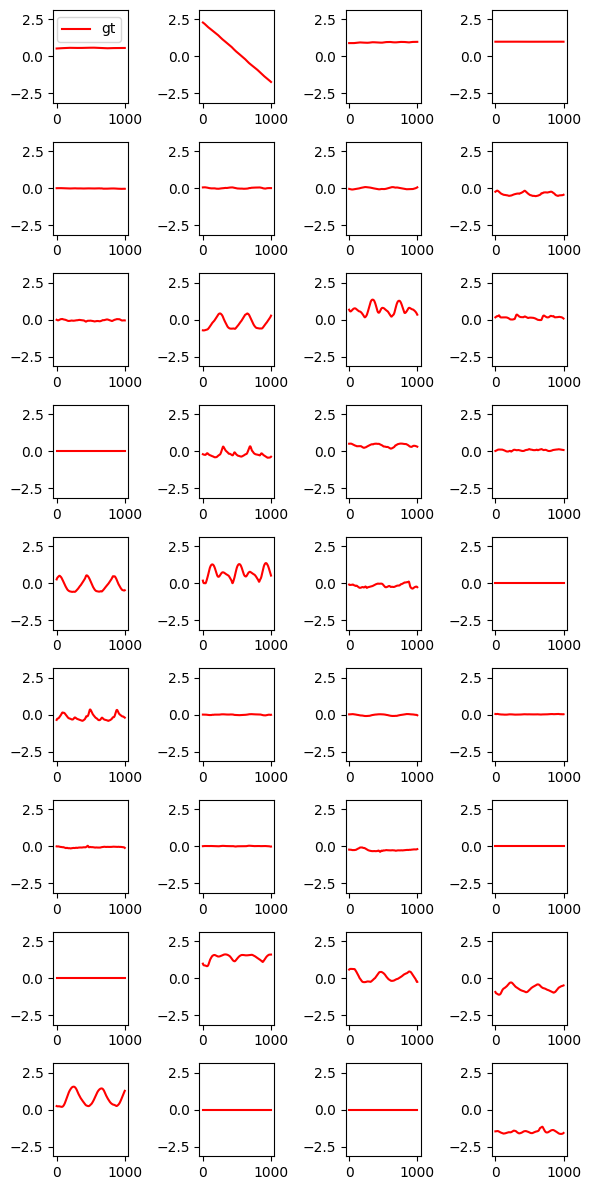

In [19]:
# interpolate each joint
import numpy as np
from scipy.interpolate import interp1d
qpos = env.expert['qpos']
qpos.shape
qpos_interp = interp1d(np.arange(qpos.shape[0]), qpos, axis=0, kind='cubic')
qpos_interp = qpos_interp(np.linspace(0, qpos.shape[0]-1, 1000))
plot_qpos(qpos_interp)

In [ ]:
import os
import sys
sys.path.append(os.getcwd())

from khrylib.utils import *
from khrylib.utils.transformation import quaternion_from_euler
from mujoco_py import load_model_from_path, MjSim
from khrylib.rl.envs.common.mjviewer import MjViewer
from khrylib.mocap.pose import load_amc_file, interpolated_traj
import pickle
import argparse
import glfw

model_file = f'khrylib/assets/mujoco_models/mocap_v2.xml'
model = load_model_from_path(model_file)
sim = MjSim(model)
body_qposaddr = get_body_qposaddr(model)
body_qposaddr


{'root': (0, 7),
 'lfemur': (7, 10),
 'ltibia': (10, 11),
 'lfoot': (11, 14),
 'rfemur': (14, 17),
 'rtibia': (17, 18),
 'rfoot': (18, 21),
 'upperback': (21, 24),
 'lowerneck': (24, 27),
 'lclavicle': (27, 29),
 'lhumerus': (29, 32),
 'lradius': (32, 33),
 'rclavicle': (33, 35),
 'rhumerus': (35, 38),
 'rradius': (38, 39)}

In [5]:
sim.data.qpos.shape

(39,)

In [ ]:
model_file = f'khrylib/assets/mujoco_models/mocap_v2_freeze.xml'
model = load_model_from_path(model_file)
sim = MjSim(model)
body_qposaddr = get_body_qposaddr(model)
body_qposaddr
res = sim.render(255, 255)
# res

array([[[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       [[ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120],
        ...,
        [ 39, 135,  80],
        [ 39, 135,  80],
        [ 39, 135,  80]],

       ...,

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]],

       [[ 39, 134,  80],
        [ 39, 134,  80],
        [ 39, 134,  80],
        ...,
        [ 80, 181, 120],
        [ 80, 181, 120],
        [ 80, 181, 120]]

In [ ]:
def get_qpos(pose):
        # qpos is in the order of root_xyz, root_quat, body_xyz, body_quat
        qpos = np.zeros_like(sim.data.qpos)
        for bone_name, ind2 in body_qposaddr.items():
            ind1 = bone_addr[bone_name]
            if bone_name == 'root':
                trans = pose[ind1[0]:ind1[0] + 3].copy()
                trans[1], trans[2] = -trans[2], trans[1]
                angles = pose[ind1[0] + 3:ind1[1]].copy()
                quat = quaternion_from_euler(angles[0], angles[1], angles[2])
                quat[2], quat[3] = -quat[3], quat[2]
                qpos[ind2[0]:ind2[0] + 3] = trans
                qpos[ind2[0] + 3:ind2[1]] = quat
            else:
                qpos[ind2[0]:ind2[1]] = pose[ind1[0]:ind1[1]]
        return qpos
